In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ys19-2023-assignment-3/sample_submission.csv
/kaggle/input/ys19-2023-assignment-3/test_set.csv
/kaggle/input/ys19-2023-assignment-3/valid_set.csv
/kaggle/input/ys19-2023-assignment-3/train_set.csv


In [2]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
!pip install torch
!pip install gensim

print("\n")
print("INSTALLATIONS COMPLETE.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 22.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=1c19f4311846dc2def491cbdb7ffd3ca9adb7e251924d9e3ff42cb8c0db6cfec
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


INSTALLATIONS COMPLETE.


## Imports

In [3]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk
import random
from torch.nn.utils import clip_grad_norm_

# HW2 new imports
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F

print('Imports done.')

Imports done.


## Data preprocessing

In [4]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/train_set.csv')
valid_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/valid_set.csv')
test_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/test_set.csv')

df.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


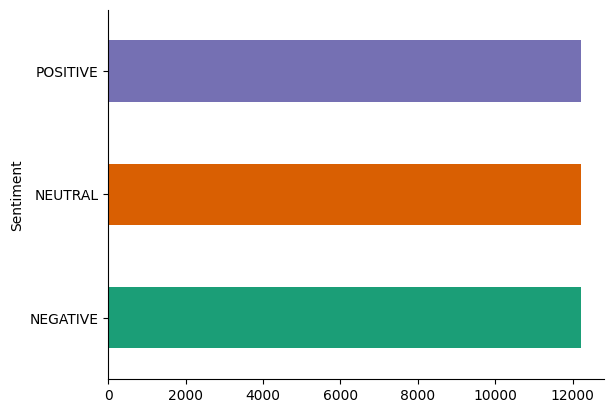

In [5]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

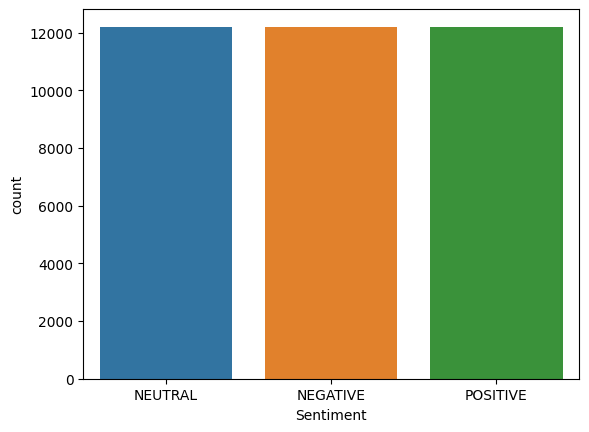

In [6]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

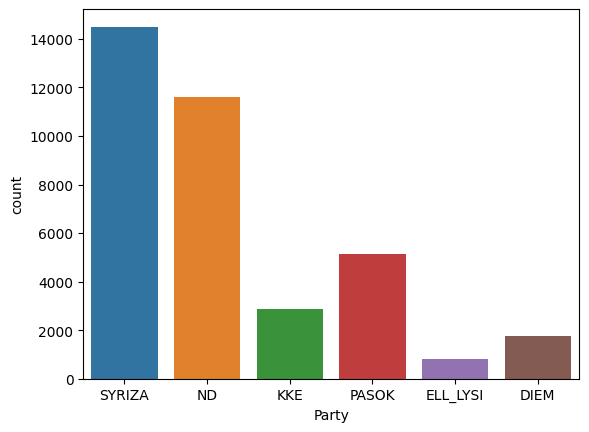

In [7]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [8]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,αδιακοπα, αι, ακομα, ακομη, ακριβως, αληθεια, αληθινα, αλλα, αλλαχου, αλλες, αλλη, αλλην, αλλης, αλλιως, αλλιωτικα, αλλο, αλλοι, αλλοιως, αλλοιωτικα, αλλον, αλλος, αλλοτε, αλλου, αλλους, αλλων, αμα, αμεσα, αμεσως, αν, ανα, αναμεσα, αναμεταξυ, ανευ, αντι, αντιπερα, αντις, ανω, ανωτερω, αξαφνα, απ, απεναντι, απο, αποψε, αρα, αραγε, αργα, αργοτερο, αριστερα, αρκετα, αρχικα, ας, αυριο, αυτα, αυτες, αυτη, αυτην, αυτης, αυτο, αυτοι, αυτον, αυτος, αυτου, αυτους, αυτων, αφοτου, αφου, βεβαια, βεβαιοτατα, γι, για, γρηγορα, γυρω, δα, δε, δεινα, δεν, δεξια, δηθεν, δηλαδη, δι, δια, διαρκως, δικα, δικο, δικοι, δικος, δικου, δικους, διολου, διπλα, διχως, εαν, εαυτο, εαυτον, εαυτου, εαυτους, εαυτων, εγκαιρα, εγκαιρως, εγω, εδω, ειδεμη, ειθε, ειμαι, ειμαστε, ειναι, εις, εισαι, εισαστε, ειστε, ειτε, ειχα, ειχαμε, ειχαν, ειχατε, ειχε, ειχες, εκαστα, εκαστες, εκαστη, εκαστην, εκαστης, εκαστο, εκαστοι, εκαστον, εκαστος, εκαστου, εκαστους, εκαστων, εκει, εκεινα, εκεινες, εκεινη, εκεινην, εκεινης, εκεινο, εκεινοι, εκεινον, εκεινος, εκεινου, εκεινους, εκεινων, εκτος, εμας, εμεις, εμενα, εμπρος, εν, ενα, εναν, ενας, ενος, εντελως, εντος, εντωμεταξυ, ενω, εξ, εξαφνα, εξης, εξισου, εξω, επανω, επειδη, επειτα, επι, επισης, επομενως, εσας, εσεις, εσενα, εστω, εσυ, ετερα, ετεραι, ετερας, ετερες, ετερη, ετερης, ετερο, ετεροι, ετερον, ετερος, ετερου, ετερους, ετερων, ετουτα, ετουτες, ετουτη, ετουτην, ετουτης, ετουτο, ετουτοι, ετουτον, ετουτος, ετουτου, ετουτους, ετουτων, ετσι, ευγε, ευθυς, ευτυχως, εφεξης, εχει, εχεις, εχετε, εχθες, εχομε, εχουμε, εχουν, εχτες, εχω, εως, η, ηδη, ημασταν, ημαστε, ημουν, ησασταν, ησαστε, ησουν, ηταν, ητανε, ητοι, ηττον, θα, ι, ιδια, ιδιαν, ιδιας, ιδιες, ιδιο, ιδιοι, ιδιον, ιδιος, ιδιου, ιδιους, ιδιων, ιδιως, ιι, ιιι, ισαμε, ισια, ισως,κ,καθε, καθεμια, καθεμιας, καθενα, καθενας, καθενος, καθετι, καθολου, καθως, και, κακα, κακως, καλα, καλως, καμια, καμιαν, καμιας, καμποσα, καμποσες, καμποση, καμποσην, καμποσης, καμποσο, καμποσοι, καμποσον, καμποσος, καμποσου, καμποσους, καμποσων, κανεις, κανεν, κανενα, κανεναν, κανενας, κανενος, καποια, καποιαν, καποιας, καποιες, καποιο, καποιοι, καποιον, καποιος, καποιου, καποιους, καποιων, καποτε, καπου, καπως, κατ ,κατα, κατι, κατιτι, κατοπιν, κατω, κιολας,κι, κλπ, κοντα, κτλ, κυριως, λιγακι, λιγο, λιγωτερο, λογω, λοιπα, λοιπον, μα, μαζι, μακαρι, μακρυα, μαλιστα, μαλλον, μας, με, μεθαυριο, μειον, μελει, μελλεται, μεμιας, μεν, μερικα, μερικες, μερικοι, μερικους, μερικων, μεσα, μετ, μετα, μεταξυ, μεχρι, μη, μηδε, μην, μηπως, μητε, μια, μιαν, μιας, μολις, μολονοτι, μοναχα, μονες, μονη, μονην, μονης, μονο, μονοι, μονομιας, μονος, μονου, μονους, μονων, μου, μπορει, μπορουν, μπραβο, μπρος, να, ναι, νωρις, ξανα, ξαφνικα, ο, οι, ολα, ολες, ολη, ολην, ολης, ολο, ολογυρα, ολοι, ολον, ολονεν, ολος, ολοτελα, ολου, ολους, ολων, ολως, ολωσδιολου, ομως, οποια, οποιαδηποτε, οποιαν, οποιανδηποτε, οποιας, οποιασδηποτε, οποιδηποτε, οποιες, οποιεσδηποτε, οποιο, οποιοδηποτε, οποιοι, οποιον, οποιονδηποτε, οποιος, οποιοσδηποτε, οποιου, οποιουδηποτε, οποιους, οποιουσδηποτε, οποιων, οποιωνδηποτε, οποτε, οποτεδηποτε, οπου, οπουδηποτε, οπως, ορισμενα, ορισμενες, ορισμενων, ορισμενως, οσα, οσαδηποτε, οσες, οσεσδηποτε, οση, οσηδηποτε, οσην, οσηνδηποτε, οσης, οσησδηποτε, οσο, οσοδηποτε, οσοι, οσοιδηποτε, οσον, οσονδηποτε, οσος, οσοσδηποτε, οσου, οσουδηποτε, οσους, οσουσδηποτε, οσων, οσωνδηποτε, οταν, οτι, οτιδηποτε, οτου, ου, ουδε, ουτε, οχι, παλι, παντοτε, παντου, παντως, παρα, περα, περι, περιπου, περισσοτερο, περσι, περυσι, πια, πιθανον, πιο, πισω, πλαι, πλεον, πλην, ποια, ποιαν, ποιας, ποιες, ποιο, ποιοι, ποιον, ποιος, ποιου, ποιους, ποιων, πολυ, ποσες, ποση, ποσην, ποσης, ποσοι, ποσος, ποσους, ποτε, που, πουθε, πουθενα, πρεπει, πριν, προ, προκειμενου, προκειται, προπερσι, προς, προτου, προχθες, προχτες, πρωτυτερα, πως, σαν, σας, σε, σεις, σημερα, σιγα, σου, στα, στη, στην, στης, στις, στο, στον, στου, στους, στων, συγχρονως, συν, συναμα, συνεπως, συνηθως, συχνα, συχνας, συχνες, συχνη, συχνην, συχνης, συχνο, συχνοι, συχνον, συχνος, συχνου, συχνου, συχνους, συχνων, συχνως, σχεδον, σωστα, τα, ταδε, ταυτα, ταυτες, ταυτη, ταυτην, ταυτης, ταυτο,ταυτον, ταυτος, ταυτου, ταυτων, ταχα, ταχατε, τελικα, τελικως, τες, τετοια, τετοιαν, τετοιας, τετοιες, τετοιο, τετοιοι, τετοιον, τετοιος, τετοιου, τετοιους, τετοιων, τη, την, της, τι, τιποτα, τιποτε, τις, το, τοι, τον, τος, τοσα, τοσες, τοση, τοσην, τοσης, τοσο, τοσοι, τοσον, τοσος, τοσου, τοσους, τοσων, τοτε, του, τουλαχιστο, τουλαχιστον, τους, τουτα, τουτες, τουτη, τουτην, τουτης, τουτο, τουτοι, τουτοις, τουτον, τουτος, τουτου, τουτους, τουτων, τυχον, των, τωρα, υπ, υπερ, υπο, υποψη, υποψιν, υστερα, φετος, χαμηλα, χθες, χτες, χωρις, χωριστα, ψηλα, ω, ωραια, ως, ωσαν, ωσοτου, ωσπου, ωστε, ωστοσο, ωχ'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [9]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([“”!?.»«,:;()\"'%&-_|–€$΄#])|([#@]\S+)", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]
test_df['Text'] = [clean_tweet(tweet) for tweet in test_df['Text']]
valid_df['Text'] = [clean_tweet(tweet) for tweet in valid_df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
test_english_words = [find_english_words(text) for text in test_df['Text']]
valid_english_words = [find_english_words(text) for text in valid_df['Text']]

def lists_to_list_skip_empty(list_of_lists):
    # Flatten the list of lists, skipping empty lists
    flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
    return flat_list

final_list = lists_to_list_skip_empty(english_words)
final_list_no_dupes = list(set(final_list))

test_final_list = lists_to_list_skip_empty(test_english_words)
test_final_list_no_dupes = list(set(test_final_list))

valid_final_list = lists_to_list_skip_empty(valid_english_words)
valid_final_list_no_dupes = list(set(valid_final_list))

stop_words_separated.extend(final_list_no_dupes) # add English words to stop words so they can be removed.
stop_words_separated.extend(test_final_list_no_dupes)
stop_words_separated.extend(valid_final_list_no_dupes)

# remove diacritics from Text column
text_no_diacritics = []
test_no_diacritics = []
valid_no_diacritics = []

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)
    
for tweet in test_df['Text']:
    text2 = ud.normalize('NFD',tweet).translate(d)
    test_no_diacritics.append(text2)

for tweet in valid_df['Text']:
    text3 = ud.normalize('NFD',tweet).translate(d)
    valid_no_diacritics.append(text3)
    
df['Text'] = text_no_diacritics
test_df['Text'] = test_no_diacritics
valid_df['Text'] = valid_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
valid_df['Text'] = valid_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.
print('\n')
print('TEST SET BELOW')
print(test_df['Text'])
print('\n')
print('VALID SET BELOW')
print(valid_df['Text'])

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        απολυμανσηκοριοι απεντομωσηκοριος απολυμανσεις...
1        εξι νεες επιστολες μακεδονια καινε νδ μητσοτακ...
2         ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες
3                      μνημονιακοτατο μερα εκλογες τωρακκε
4                         συγκλονιστικο ψυχασθενεια τσιπρα
                               ...                        
36625    κουλης μητσοτακης λεει ψεματαδεν αδειασε μπαμπ...
36626    προσεξε σκισει καλσον χαλια νεα φωτογραφια ομο...
36627    θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες...
36628    μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφ...
36629                              ενταξει επεισες κκε 🤘❤️
Name: Text, Length: 36630, dtype: object


TEST SET BELOW
0        κυριακος μητσοτακης ξερει μουσειο βεργινας μεσ...
1        συνεντευξη υποψηφιας βουλευτη νεα δημοκρατια β...
2        εκλογες μαθητες φοιτητες ψηφιζουμε τροπο αγωνι...
3        γεννηματα κιναλ γινει δεκανικι ενδιαφερουν υπο...
4        κυριακη εκλογων οκτωβρης ξημερωματα δευτερας ξ..

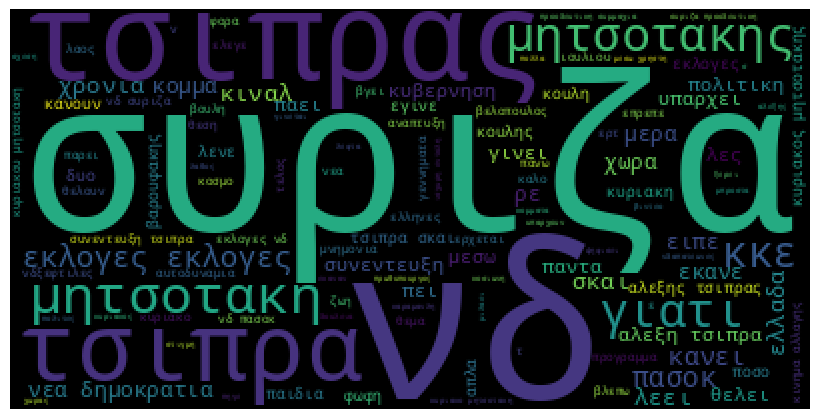

In [10]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    


# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)


wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

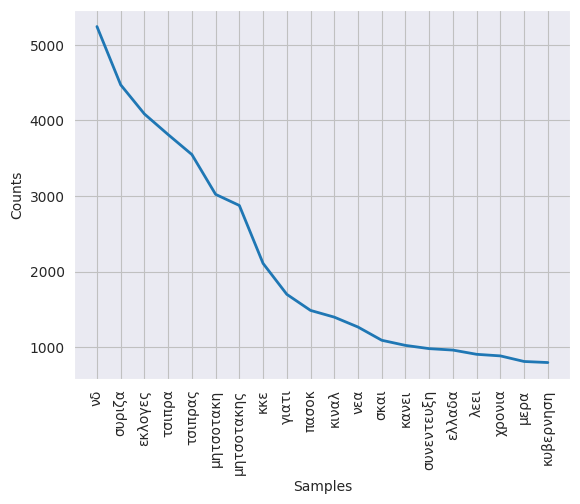

In [11]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [12]:
# X = df['Lemmas'] # Lemma as feature, doesn't really increase performance of f1-score.
# X = df['Tokens'] # same as above for tokens.
X_train = df['Text'] # 40% f1-score , best feature as of yet
X_test = test_df['Text']
y_train = df['Sentiment'] # labels

X_valid = valid_df['Text']
y_valid = valid_df['Sentiment'] # these two will be used for metrics

def simple_tokenizer(sentence):
    tokens = sentence.split()  # Split the sentence into a list of words
    return tokens

# tokenize text column and perform below processes for all datasets.
df['Tokens'] = df['Text'].apply(simple_tokenizer)
test_df['Tokens'] = test_df['Text'].apply(simple_tokenizer)
valid_df['Tokens'] = valid_df['Text'].apply(simple_tokenizer)

# Train Word2Vec model
sentences = df['Tokens'].tolist()
test_sentences = test_df['Tokens'].tolist()
valid_sentences = valid_df['Tokens'].tolist()

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Creates embeddings for each tweet
def get_tweet_embedding(tweet):
    word_embeddings = [word2vec_model.wv[word] for word in tweet if word in word2vec_model.wv]
    if not word_embeddings:
        zeroes_list = [0] * 100
        return zeroes_list
            
#         return None  # Handle the case where no words have embeddings
    tweet_embedding = sum(word_embeddings) / len(word_embeddings)  # Simple average
    return tweet_embedding

# Convert tweet tokens to embeddings
tweet_embeddings_train = [get_tweet_embedding(tweet) for tweet in sentences]
tweet_embeddings_test = [get_tweet_embedding(tweet) for tweet in test_sentences]
tweet_embeddings_valid = [get_tweet_embedding(tweet) for tweet in valid_sentences]


# Convert labels to one-hot encoded tensors
label_embeddings_train = pd.get_dummies(df['Sentiment']).values
label_embeddings_valid = pd.get_dummies(valid_df['Sentiment']).values

# Below part is used to correlate the numbers 0,1,2 to their respective labels (POSITIVE,NEUTRAL,NEGATIVE) for predictions
label_encoded_train = pd.get_dummies(df['Sentiment'])
label_encoded_valid = pd.get_dummies(valid_df['Sentiment'])

label_mapping_train = {i: label for i, label in enumerate(label_encoded_train.columns)}
label_mapping_valid = {i: label for i, label in enumerate(label_encoded_valid.columns)}

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(tweet_embeddings_train)
y_train_tensor = torch.FloatTensor(label_embeddings_train)

X_test_tensor = torch.FloatTensor(tweet_embeddings_test)

X_valid_tensor = torch.FloatTensor(tweet_embeddings_valid)
y_valid_tensor = torch.FloatTensor(label_embeddings_valid)


print('X_train_tensor shape:', X_train_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)

print('X_test_tensor shape: ', X_test_tensor.shape)

print('X_valid_tensor shape: ', X_valid_tensor.shape)
print('y_valid_tensor shape: ', y_valid_tensor.shape)

/tmp/ipykernel_19/79449557.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train_tensor = torch.FloatTensor(tweet_embeddings_train)


X_train_tensor shape: torch.Size([36630, 100])
y_train_tensor shape: torch.Size([36630, 3])
X_test_tensor shape:  torch.Size([10470, 100])
X_valid_tensor shape:  torch.Size([5232, 100])
y_valid_tensor shape:  torch.Size([5232, 3])


In [13]:
X_train_tensor = X_train_tensor.unsqueeze(1)  # Adds a dimension at index 1
X_valid_tensor = X_valid_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print('Data loading complete.')

Data loading complete.


## most similar word visualization

In [14]:
# Picking some common words to show visualizations
most_similar_mitsotakis = word2vec_model.wv.most_similar('μητσοτακης')

print(f'Most semantically similar to word Mitsotakis:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_mitsotakis:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Mitsotakis:

     word            similarity score
     μητσοτακης…    0.9547027349472046
     χωρων          0.9515827298164368
     ζητησε         0.9509779810905457
     διαφορετικος   0.9440712332725525
     απελευθερωσε   0.9418005347251892
     μακρυνιτσα     0.9397727847099304
     συνοδος        0.9377662539482117
     υπερηφανους    0.9341276288032532
     αβραμοπουλος   0.9335430860519409
     αποδειχθει     0.9329411387443542


In [15]:
most_similar_tsipras = word2vec_model.wv.most_similar('τσιπρας')

print(f'Most semantically similar to word Tsipras:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_tsipras:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Tsipras:

     word            similarity score
     ξεβρακωμα      0.9591887593269348
     🔴              0.9571133852005005
     συμβιβαστηκαμε 0.9513048529624939
     σπαει          0.9492200613021851
     μετανιωνω      0.9466826319694519
     σκαιτσιπρας    0.9450240135192871
     τσιπραςσυνταγμα0.944040834903717
     πρωινες        0.9435499310493469
     ανακοινωνει    0.9427955746650696
     ζαγορα         0.9409149885177612


## Linear substructure visualization

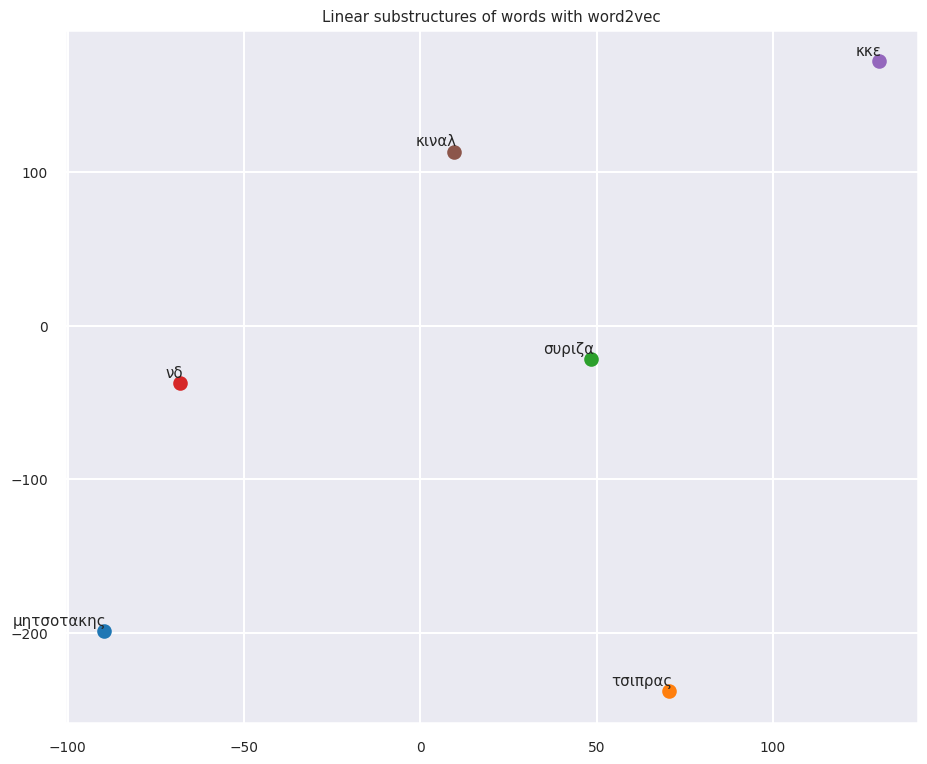

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

vocab = ["μητσοτακης", "τσιπρας", "συριζα", "νδ", "κκε", "κιναλ"]

def glove_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    wordvecs_array = np.array(wordvecs)
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42) #T-distributed Stochastic Neighbor Embedding
    coordinates = tsne_model.fit_transform(wordvecs_array) #The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance.

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])


    plt.figure(figsize=(11,9))
    plt.title('Linear substructures of words with word2vec')
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

glove_plot(word2vec_model)

## RNN creation (Stacked and bidirectional)

In [17]:
# RNN stacked bi-directional model
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers):
        super(RNN, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

## Training and evaluation

Epoch   0 		 Training Loss: 1.09487 		 Validation Loss: 1.09088


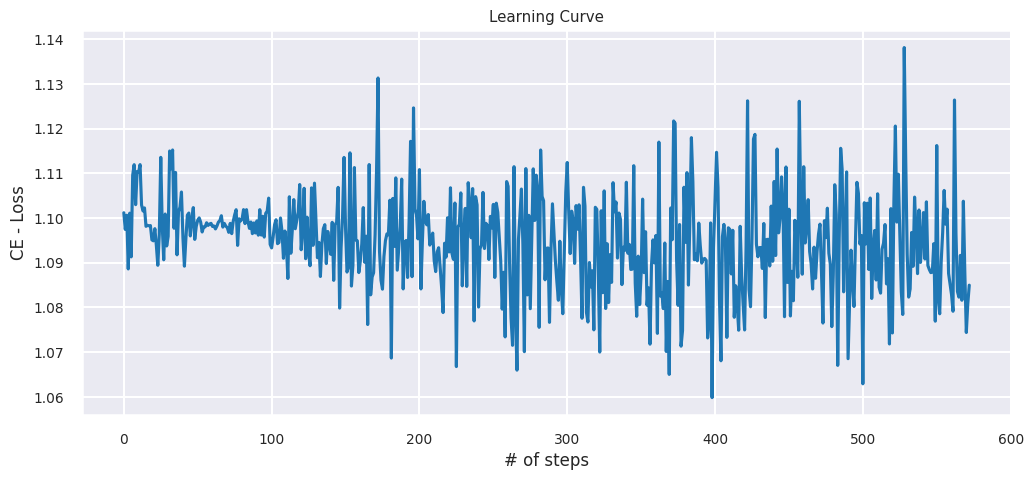

In [18]:
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
model = RNN(cell_type, input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train NN for one epoch so we can get Learning curve for steps.

for epoch in range(1):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

    
# Plot results (Learning curve)
plt.figure(figsize=(12,5))
plt.plot(batch_losses)
plt.title('Learning Curve')
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

In [19]:
# LSTM run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
f1_scores = {} # here I will save all f1 scores and later on get the best NN's results
valid_preds = {} # here I will save all valid predictions and later on get the best NN's results
test_preds = {} # here I will save all test predictions and later on get the best NN's results


# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Best number for now: 60
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_lstm = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_lstm  = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_lstm))

lstm_f1 = f1_score(original_labels_valid,original_label_predictions_valid_lstm,average='micro')
f1_scores['lstm'] = lstm_f1
valid_preds['lstm'] = original_label_predictions_valid_lstm
test_preds['lstm'] = original_label_predictions_test_lstm
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_lstm))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_lstm,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_lstm,average=None))

Epoch   0 		 Training Loss: 1.09493 		 Validation Loss: 1.09273
Epoch   1 		 Training Loss: 1.09113 		 Validation Loss: 1.08912
Epoch   2 		 Training Loss: 1.08947 		 Validation Loss: 1.08883
Epoch   3 		 Training Loss: 1.08946 		 Validation Loss: 1.08685
Epoch   4 		 Training Loss: 1.08818 		 Validation Loss: 1.08741
Epoch   5 		 Training Loss: 1.08617 		 Validation Loss: 1.08391
Epoch   6 		 Training Loss: 1.08478 		 Validation Loss: 1.08344
Epoch   7 		 Training Loss: 1.08344 		 Validation Loss: 1.08543
Epoch   8 		 Training Loss: 1.08273 		 Validation Loss: 1.08245
Epoch   9 		 Training Loss: 1.08216 		 Validation Loss: 1.07902
Epoch  10 		 Training Loss: 1.08237 		 Validation Loss: 1.08022
Epoch  11 		 Training Loss: 1.08098 		 Validation Loss: 1.07780
Epoch  12 		 Training Loss: 1.08073 		 Validation Loss: 1.07930
Epoch  13 		 Training Loss: 1.08017 		 Validation Loss: 1.07646
Epoch  14 		 Training Loss: 1.07910 		 Validation Loss: 1.07527
Epoch  15 		 Training Loss: 1.07882 		 V

In [20]:
# RNN Run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'RNN'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
rnn_model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = rnn_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    rnn_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = rnn_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
rnn_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = rnn_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_rnn = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
rnn_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = rnn_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_rnn = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= RNN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_rnn))

rnn_f1 = f1_score(original_labels_valid,original_label_predictions_valid_rnn,average='micro')
f1_scores['rnn'] = rnn_f1
valid_preds['rnn'] = original_label_predictions_valid_rnn
test_preds['rnn'] = original_label_predictions_test_rnn
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_rnn))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_rnn,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_rnn,average=None))

Epoch   0 		 Training Loss: 1.09429 		 Validation Loss: 1.09110
Epoch   1 		 Training Loss: 1.09135 		 Validation Loss: 1.08788
Epoch   2 		 Training Loss: 1.09025 		 Validation Loss: 1.09046
Epoch   3 		 Training Loss: 1.08881 		 Validation Loss: 1.08538
Epoch   4 		 Training Loss: 1.08697 		 Validation Loss: 1.08643
Epoch   5 		 Training Loss: 1.08564 		 Validation Loss: 1.08210
Epoch   6 		 Training Loss: 1.08437 		 Validation Loss: 1.08163
Epoch   7 		 Training Loss: 1.08399 		 Validation Loss: 1.07866
Epoch   8 		 Training Loss: 1.08336 		 Validation Loss: 1.07993
Epoch   9 		 Training Loss: 1.08243 		 Validation Loss: 1.08151
Epoch  10 		 Training Loss: 1.08292 		 Validation Loss: 1.08017
Epoch  11 		 Training Loss: 1.08138 		 Validation Loss: 1.07911
Epoch  12 		 Training Loss: 1.08171 		 Validation Loss: 1.08031
Epoch  13 		 Training Loss: 1.08064 		 Validation Loss: 1.07853
Epoch  14 		 Training Loss: 1.08065 		 Validation Loss: 1.07934
Epoch  15 		 Training Loss: 1.07976 		 V

In [21]:
# GRU Run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'GRU'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
gru_model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = gru_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    gru_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = gru_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
gru_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = gru_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_gru = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
gru_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = gru_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= GRU SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

gru_accuracy = accuracy_score(original_labels_valid,original_label_predictions_valid)
f1_scores['gru'] = gru_accuracy
valid_preds['gru'] = original_label_predictions_valid
test_preds['gru'] = original_label_predictions_test_gru
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09387 		 Validation Loss: 1.08924
Epoch   1 		 Training Loss: 1.09081 		 Validation Loss: 1.08811
Epoch   2 		 Training Loss: 1.08974 		 Validation Loss: 1.08806
Epoch   3 		 Training Loss: 1.08807 		 Validation Loss: 1.08522
Epoch   4 		 Training Loss: 1.08656 		 Validation Loss: 1.08603
Epoch   5 		 Training Loss: 1.08487 		 Validation Loss: 1.08167
Epoch   6 		 Training Loss: 1.08450 		 Validation Loss: 1.08119
Epoch   7 		 Training Loss: 1.08326 		 Validation Loss: 1.08069
Epoch   8 		 Training Loss: 1.08212 		 Validation Loss: 1.08035
Epoch   9 		 Training Loss: 1.08223 		 Validation Loss: 1.08246
Epoch  10 		 Training Loss: 1.08164 		 Validation Loss: 1.07905
Epoch  11 		 Training Loss: 1.08124 		 Validation Loss: 1.07919
Epoch  12 		 Training Loss: 1.08081 		 Validation Loss: 1.07963
Epoch  13 		 Training Loss: 1.08050 		 Validation Loss: 1.07707
Epoch  14 		 Training Loss: 1.08036 		 Validation Loss: 1.07745
Epoch  15 		 Training Loss: 1.07945 		 V

## Testing skip connections LSTM

In [22]:
# RNN stacked bi-directional model
class RNN_skip(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers):
        super(RNN_skip, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        skip_connection = x
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
            # adding skip connections
            r_out = r_out + skip_connection
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [23]:
# LSTM run (Skip connections)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
skip_model = RNN_skip(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(skip_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = skip_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    skip_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = skip_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
skip_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = skip_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_skip = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
skip_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = skip_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (SKIP CONNECTIONS) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

skip_connections_f1 = f1_score(original_labels_valid,original_label_predictions_valid,average='micro')
f1_scores['skip'] = skip_connections_f1
valid_preds['skip'] = original_label_predictions_valid
test_preds['skip'] = original_label_predictions_test_skip
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09580 		 Validation Loss: 1.09023
Epoch   1 		 Training Loss: 1.09163 		 Validation Loss: 1.09550
Epoch   2 		 Training Loss: 1.08996 		 Validation Loss: 1.09010
Epoch   3 		 Training Loss: 1.08817 		 Validation Loss: 1.08325
Epoch   4 		 Training Loss: 1.08709 		 Validation Loss: 1.08521
Epoch   5 		 Training Loss: 1.08538 		 Validation Loss: 1.08168
Epoch   6 		 Training Loss: 1.08462 		 Validation Loss: 1.08013
Epoch   7 		 Training Loss: 1.08441 		 Validation Loss: 1.08201
Epoch   8 		 Training Loss: 1.08334 		 Validation Loss: 1.08208
Epoch   9 		 Training Loss: 1.08285 		 Validation Loss: 1.07960
Epoch  10 		 Training Loss: 1.08212 		 Validation Loss: 1.07775
Epoch  11 		 Training Loss: 1.08200 		 Validation Loss: 1.07947
Epoch  12 		 Training Loss: 1.08141 		 Validation Loss: 1.08264
Epoch  13 		 Training Loss: 1.08097 		 Validation Loss: 1.07910
Epoch  14 		 Training Loss: 1.08077 		 Validation Loss: 1.07894
Epoch  15 		 Training Loss: 1.08016 		 V

## Gradient clipping LSTM test

In [24]:
class RNN_grad_clip(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers, clip_value):
        super(RNN_grad_clip, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.clip_value = clip_value
        
    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [25]:
# LSTM run (Gradient Clipping)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
clip_value= 1.0

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
grad_clip_model = RNN_grad_clip(cell_type,input_size, hidden_size, output_size, num_hidden_layers, clip_value)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(grad_clip_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = grad_clip_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        
        # Perform gradient clipping
        clip_grad_norm_(grad_clip_model.parameters(), grad_clip_model.clip_value)
        
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    grad_clip_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = grad_clip_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
grad_clip_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = grad_clip_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_grad_clip = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
grad_clip_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = grad_clip_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (GRADIENT CLIPPING) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

grad_clip_f1 = f1_score(original_labels_valid,original_label_predictions_valid,average='micro')
f1_scores['grad_clip'] = grad_clip_f1
valid_preds['grad_clip'] = original_label_predictions_valid
test_preds['grad_clip'] = original_label_predictions_test_grad_clip
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09524 		 Validation Loss: 1.09156
Epoch   1 		 Training Loss: 1.09160 		 Validation Loss: 1.09016
Epoch   2 		 Training Loss: 1.09016 		 Validation Loss: 1.08901
Epoch   3 		 Training Loss: 1.08954 		 Validation Loss: 1.08967
Epoch   4 		 Training Loss: 1.08759 		 Validation Loss: 1.08569
Epoch   5 		 Training Loss: 1.08548 		 Validation Loss: 1.08342
Epoch   6 		 Training Loss: 1.08455 		 Validation Loss: 1.08262
Epoch   7 		 Training Loss: 1.08380 		 Validation Loss: 1.08209
Epoch   8 		 Training Loss: 1.08294 		 Validation Loss: 1.07951
Epoch   9 		 Training Loss: 1.08227 		 Validation Loss: 1.07922
Epoch  10 		 Training Loss: 1.08174 		 Validation Loss: 1.07906
Epoch  11 		 Training Loss: 1.08100 		 Validation Loss: 1.07924
Epoch  12 		 Training Loss: 1.08071 		 Validation Loss: 1.08011
Epoch  13 		 Training Loss: 1.08075 		 Validation Loss: 1.07860
Epoch  14 		 Training Loss: 1.08013 		 Validation Loss: 1.07756
Epoch  15 		 Training Loss: 1.07983 		 V

## Attention mechanism (Bonus)

In [26]:
class RNN_Attention(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers, num_heads):
        super(RNN_Attention, self).__init__()

        cells = {
            "RNN" : nn.RNN,
            "LSTM"    : nn.LSTM,
            "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         
            input_size = input_size,           
            hidden_size = hidden_size,         
            batch_first = True, 
            bidirectional = True, 
            num_layers = num_hidden_layers, 
            dropout = 0.2 
        )

        self.multihead_attn = nn.MultiheadAttention(hidden_size*2, num_heads=num_heads, dropout=0.2) # Add multihead attention layer

        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
       
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
       
        r_out = r_out.permute(1, 0, 2) # Transpose the output for MultiheadAttention

        r_out, _ = self.multihead_attn(r_out, r_out, r_out) # Pass the output through the attention layer

        r_out = r_out.permute(1, 0, 2) # Transpose the output back to original

        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
       
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [27]:
# LSTM run (Attention mechanism)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
num_heads = 4

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
attention_model = RNN_Attention(cell_type,input_size, hidden_size, output_size, num_hidden_layers, num_heads)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
#         print("batch",x_batch.shape)
        y_pred = attention_model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    attention_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = attention_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
attention_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = attention_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_attention = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
attention_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = attention_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_attention = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (ATTENTION) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_attention))

attention_f1 = accuracy_score(original_labels_valid,original_label_predictions_valid_attention)
f1_scores['attention'] = attention_f1
valid_preds['attention'] = original_label_predictions_valid_attention
test_preds['attention'] = original_label_predictions_test_attention
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_attention))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_attention,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_attention,average=None))

Epoch   0 		 Training Loss: 1.09635 		 Validation Loss: 1.09406
Epoch   1 		 Training Loss: 1.09288 		 Validation Loss: 1.09057
Epoch   2 		 Training Loss: 1.09147 		 Validation Loss: 1.08930
Epoch   3 		 Training Loss: 1.09066 		 Validation Loss: 1.08891
Epoch   4 		 Training Loss: 1.08946 		 Validation Loss: 1.08817
Epoch   5 		 Training Loss: 1.08862 		 Validation Loss: 1.08629
Epoch   6 		 Training Loss: 1.08600 		 Validation Loss: 1.08452
Epoch   7 		 Training Loss: 1.08560 		 Validation Loss: 1.08279
Epoch   8 		 Training Loss: 1.08452 		 Validation Loss: 1.08102
Epoch   9 		 Training Loss: 1.08401 		 Validation Loss: 1.08040
Epoch  10 		 Training Loss: 1.08321 		 Validation Loss: 1.08191
Epoch  11 		 Training Loss: 1.08255 		 Validation Loss: 1.08102
Epoch  12 		 Training Loss: 1.08215 		 Validation Loss: 1.08079
Epoch  13 		 Training Loss: 1.08152 		 Validation Loss: 1.07920
Epoch  14 		 Training Loss: 1.08127 		 Validation Loss: 1.07805
Epoch  15 		 Training Loss: 1.08099 		 V

## Confusion matrix

In [28]:
max_result_nn = max(f1_scores, key=f1_scores.get)
final_valid_preds = []

if max_result_nn == 'lstm':
    final_valid_preds = valid_preds['lstm']
    print('lstm best.')
elif max_result_nn == 'rnn':
    final_valid_preds = valid_preds['rnn']
    print('rnn best.')
elif max_result_nn == 'gru':
    final_valid_preds = valid_preds['gru']
    print('gru best.')
elif max_result_nn == 'skip':
    final_valid_preds = valid_preds['skip']
    print('skip connections best.')
elif max_result_nn == 'grad_clip':
    final_valid_preds = valid_preds['grad_clip']
    print('gradient clipping best.')
elif max_result_nn == 'attention':
    final_valid_preds = valid_preds['attention']
    print('attention mechanism best.')

gru best.


In [29]:
conf_matrix = confusion_matrix(y_valid,final_valid_preds)
print(confusion_matrix(y_valid,final_valid_preds))

[[811 527 406]
 [823 522 399]
 [846 508 390]]


## Learning and ROC curves

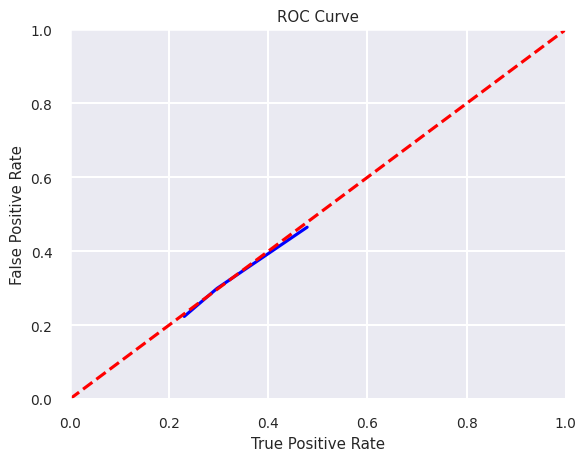

In [30]:
# ROC Curve
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix) #false positive
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix) # false negative
TP = np.diag(conf_matrix) # true positive
TN = conf_matrix.sum() - (FP + FN + TP) # True negative

TPR = TP/(TP+FN) # true positive rate
FPR = FP/(FP+TN) # false positive rate

plt.plot(FPR,TPR,'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

## Obtain predictions

In [31]:
final_test_preds = []

if max_result_nn == 'lstm':
    final_test_preds = test_preds['lstm']
    print('lstm best.')
elif max_result_nn == 'rnn':
    final_test_preds = test_preds['rnn']
    print('rnn best.')
elif max_result_nn == 'gru':
    final_test_preds = test_preds['gru']
    print('gru best.')
elif max_result_nn == 'skip':
    final_test_preds = test_preds['skip']
    print('skip connections best.')
elif max_result_nn == 'grad_clip':
    final_test_preds = test_preds['grad_clip']
    print('gradient clipping best.')
elif max_result_nn == 'attention':
    final_test_preds = test_preds['attention']
    print('attention mechanism best.')

gru best.


## Output file

In [32]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(0,10470):
        writer.writerow([i+1,final_test_preds[i]])  
    
    
print("CSV file writing complete.")

CSV file writing complete.
